In [1]:
from importlib import reload
import configparser
import json 
import os

import segmentation_models_pytorch as smp
import wandb
import torch
import numpy as np
import random

import datasets
import train_procedures
import losses
import utils
import models

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reload(datasets)
reload(train_procedures)
reload(losses)
reload(utils)
reload(models)

<module 'models' from '/trinity/home/team18/workspace/models.py'>

In [2]:
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)
cls_model = models.ClassificatorModel(model.encoder).to("cuda")

In [4]:
torch.manual_seed(0)
np.random.seed(42)
random.seed(42)

### train base model for MOSCOW and USA 

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)
state_dict = torch.load("./saved_data/msc_to_usa_tune_low_lr/epoch_50")
model.load_state_dict(state_dict)

In [12]:
train_dataloader_msc, test_dataloader_msc = datasets.get_dataloaders_msc(32)
train_dataloader_usa, test_dataloader_usa = datasets.get_dataloaders_usa(32)
#train_dataloader_common = datasets.get_dataloaders_common(32)

In [ ]:
next(iter(train_dataloader_usa))

In [14]:
config = configparser.ConfigParser()
config.read("config.ini")

opt_lr = json.loads(config.get("training", "opt_lr"))
name = config.get("meta", "name")
encoder_name = config.get("meta", "encoder_name")
description = config.get("meta", "description")
epoch_t = json.loads(config.get("training", "epoch_t"))

wandb.login()
run = wandb.init(
    # Set the project where this run will be logged
    project="SMILES2024",
    name = name,
    notes = description,
    # Track hyperparameters and run metadata
    config = {"opt_lr": opt_lr}
)

model = smp.Unet(
    encoder_name=encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

device = torch.device("cuda")
opt = torch.optim.Adam(model.parameters(), lr=opt_lr)    
scheduler = train_procedures.get_scheduler(opt, config)
#loss = losses.SoftDiceLoss().to(device)
#loss = torch.nn.CrossEntropyLoss()
loss = losses.SoftDiceCrossLoss(loss_weights=(0.5, 0.5)).to(device)
model = train_procedures.train_main_model(model, loss, opt, scheduler, train_dataloader_msc, test_dataloader_msc, name, epoch_t=epoch_t, device=device,
                                 log_flag=True, train_area="msc", test_area="msc")
wandb.finish()

100%|██████████| 200/200 [54:09<00:00, 16.25s/it]


IOS bare soil msc,▁▂▁▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇██████
IOS forest msc,▁▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
IOS grassland msc,▁▅▄▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▆▇▇████████████████
IOS open water msc,▁▅▄▅▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇██████████████
IOS settlements msc,▁▃▂▅▄▅▅▅▆▆▆▆▆▅▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇███████████
accuracy msc,▁▆▅▆▆▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇██████████████████
epoch loss msc,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
last lr,▁▄██████▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
mean IOS msc,▁▄▃▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇███████████
IOS bare soil msc,0.24034
IOS forest msc,0.9467


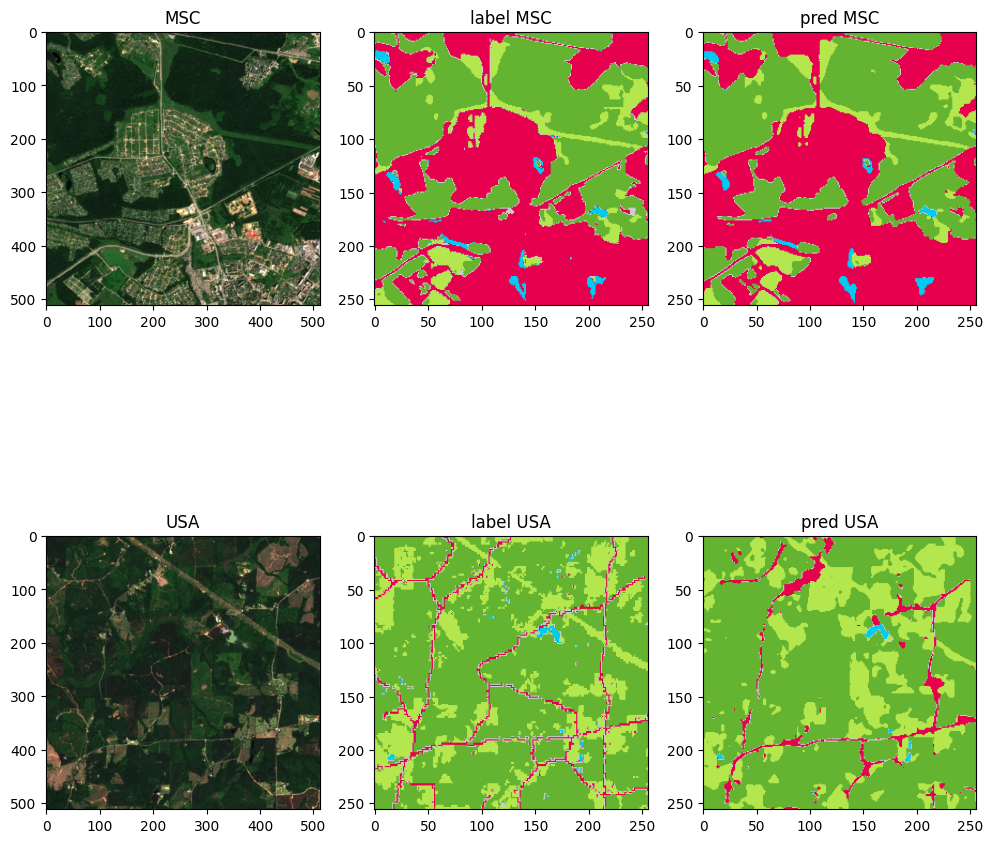

{'msc': {'IOS open water': 0.854699,
  'IOS settlements': 0.8279872,
  'IOS bare soil': 0.24034001,
  'IOS forest': 0.94669944,
  'IOS grassland': 0.86797553,
  'accuracy': 0.9486876593695747,
  'mean IOS': 0.74754024},
 'USA': {'IOS open water': 0.609506,
  'IOS settlements': 0.34111923,
  'IOS bare soil': 0.06350633,
  'IOS forest': 0.8007796,
  'IOS grassland': 0.47490782,
  'accuracy': 0.7802475094795227,
  'mean IOS': 0.4579638}}

In [15]:
train_procedures.sainty_check(model, test_dataloader_usa, test_dataloader_msc, device, idxs=(1, 2))

### Resampling method

In [350]:
dataloader_sampling = datasets.DatasetsSamplingCreator()

In [ ]:
config = configparser.ConfigParser()
config.read("config.ini")

opt_lr = json.loads(config.get("training", "opt_lr"))
name = config.get("meta", "name")
encoder_name = config.get("meta", "encoder_name")
description = config.get("meta", "description")
epoch_t = json.loads(config.get("training", "epoch_t"))
device = torch.device("cuda")

wandb.login()
run = wandb.init(
    # Set the project where this run will be logged
    project="SMILES2024",
    name = name,
    notes = description,
    # Track hyperparameters and run metadata
    config = {"opt_lr": opt_lr}
)

In [311]:
model = smp.Unet(
encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=5,                      # model output channels (number of classes in your dataset)
)
state_dict = torch.load("./saved_data/msc_model_resnet50/final")
model.load_state_dict(state_dict)
cls_model = models.ClassificatorModel(model.encoder).to("cuda")

### Get_weights_for_data

In [360]:
batch = next(iter(train_dataloader_part))

In [ ]:
weights = {}
trues_msc = []
trues_usa = []
for i in range(5):
    print(i)
    model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
    )

    state_dict = torch.load("./saved_data/msc_model_resnet50/final")
    model.load_state_dict(state_dict)

    cls_model = models.ClassificatorModel(model.encoder).to("cuda")
    opt = torch.optim.Adam(cls_model.parameters(), lr=opt_lr)    
    scheduler = train_procedures.get_scheduler(opt, config)
    loss = torch.nn.CrossEntropyLoss()
    
    dataloader_train, dataloder_pathes = dataloader_sampling[i]
    cls_model = train_procedures.train_classifier_model(cls_model, loss, opt, scheduler, dataloader_train, epoch_t=epoch_t, device=device,
                                                         log_flag=True)
    weight = train_procedures.get_predicted_cls(cls_model, dataloder_pathes, torch.device("cuda"))
    weights.update(weight)
    
    trues = train_procedures.cls_sainty_check(cls_model, test_dataloader_usa, device, label=1)
    trues_usa.append(trues)
    print(f"USA: {trues}")
    trues = train_procedures.cls_sainty_check(cls_model, test_dataloader_msc, device, label=0)
    trues_msc.append(trues)
    print(f"MSC: {trues}")
wandb.finish()
print(trues_msc)
print(trues_usa)

In [354]:
weigths_to_save = {key: value.item() for key, value in weights.items()}
torch.save(cls_model.state_dict(), f"saved_data/cls_model")

### Train with part of Moscow_data

In [413]:
train_dataloader_part = datasets.get_part_dataloader(weights)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
config = configparser.ConfigParser()
config.read("config.ini")

opt_lr = json.loads(config.get("training", "opt_lr"))
name = config.get("meta", "name")
encoder_name = config.get("meta", "encoder_name")
description = config.get("meta", "description")
epoch_t = json.loads(config.get("training", "epoch_t"))
device = torch.device("cuda")

wandb.login()
run = wandb.init(
    # Set the project where this run will be logged
    project="SMILES2024",
    name = name,
    notes = description,
    # Track hyperparameters and run metadata
    config = {"opt_lr": opt_lr}
)

model = smp.Unet(
    encoder_name=encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

device = torch.device("cuda")
opt = torch.optim.Adam(model.parameters(), lr=opt_lr)    
scheduler = train_procedures.get_scheduler(opt, config)

loss = losses.SoftDiceCrossLoss(loss_weights=(0.5, 0.5)).to(device)
model = train_procedures.train_main_model(model, loss, opt, scheduler, train_dataloader_part, test_dataloader_msc, name, epoch_t=epoch_t, device=device,
                                 log_flag=True, train_area="msc", test_area="msc")
wandb.finish()

 32%|███▏      | 64/200 [11:00<22:36,  9.98s/it]

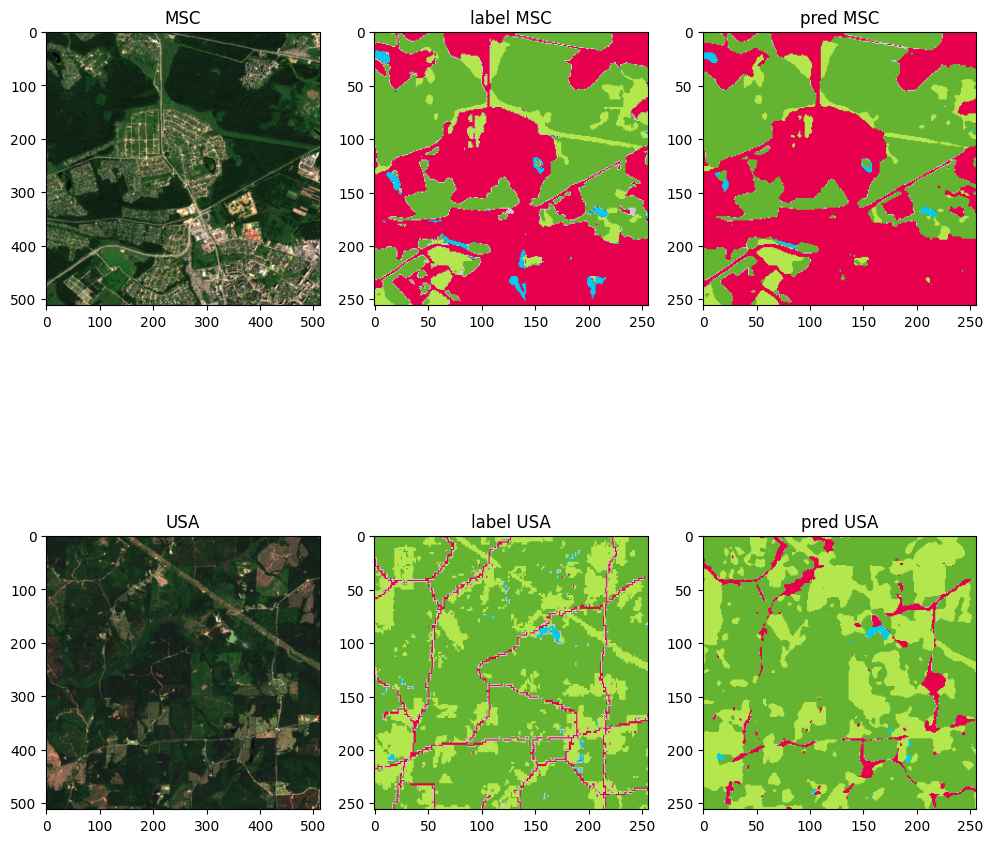

{'msc': {'IOS open water': 0.738419,
  'IOS settlements': 0.7261781,
  'IOS bare soil': 0.12308931,
  'IOS forest': 0.9130901,
  'IOS grassland': 0.7797255,
  'accuracy': 0.9177507471155237,
  'mean IOS': 0.6561004},
 'USA': {'IOS open water': 0.5975867,
  'IOS settlements': 0.31331182,
  'IOS bare soil': 0.032604996,
  'IOS forest': 0.7898084,
  'IOS grassland': 0.48013684,
  'accuracy': 0.7690951228141785,
  'mean IOS': 0.44268975}}

In [420]:
train_procedures.sainty_check(model, test_dataloader_usa, test_dataloader_msc, device, idxs=(1, 2))

### Train with weighted of Moscow_data

In [379]:
mean = np.mean([value.item() for value in weights.values()])
weights = {key: value / mean for key, value in weights.items()}

In [381]:
train_dataloader_weight = datasets.get_weighted_dataloader(weights)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
config = configparser.ConfigParser()
config.read("config.ini")

opt_lr = json.loads(config.get("training", "opt_lr"))
name = config.get("meta", "name")
encoder_name = config.get("meta", "encoder_name")
description = config.get("meta", "description")
epoch_t = json.loads(config.get("training", "epoch_t"))
device = torch.device("cuda")

wandb.login()
run = wandb.init(
    # Set the project where this run will be logged
    project="SMILES2024",
    name = name,
    notes = description,
    # Track hyperparameters and run metadata
    config = {"opt_lr": opt_lr}
)

model = smp.Unet(
    encoder_name=encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

device = torch.device("cuda")
opt = torch.optim.Adam(model.parameters(), lr=opt_lr)    
scheduler = train_procedures.get_scheduler(opt, config)

loss = losses.SoftDiceCrossWeightedLoss(loss_weights=(0.5, 0.5)).to(device)
model = train_procedures.train_main_model(model, loss, opt, scheduler, train_dataloader_weight, test_dataloader_msc, name, epoch_t=epoch_t, device=device,
                                 log_flag=True, train_area="msc", test_area="msc")
wandb.finish()

In [ ]:
loss = losses.SoftDiceCrossWeightedLoss(loss_weights=(0.5, 0.5)).to(device)
model = train_procedures.train_main_model(model, loss, opt, scheduler, train_dataloader_weight, test_dataloader_msc, name, epoch_t=epoch_t, device=device,
                                 log_flag=True, train_area="msc", test_area="msc")

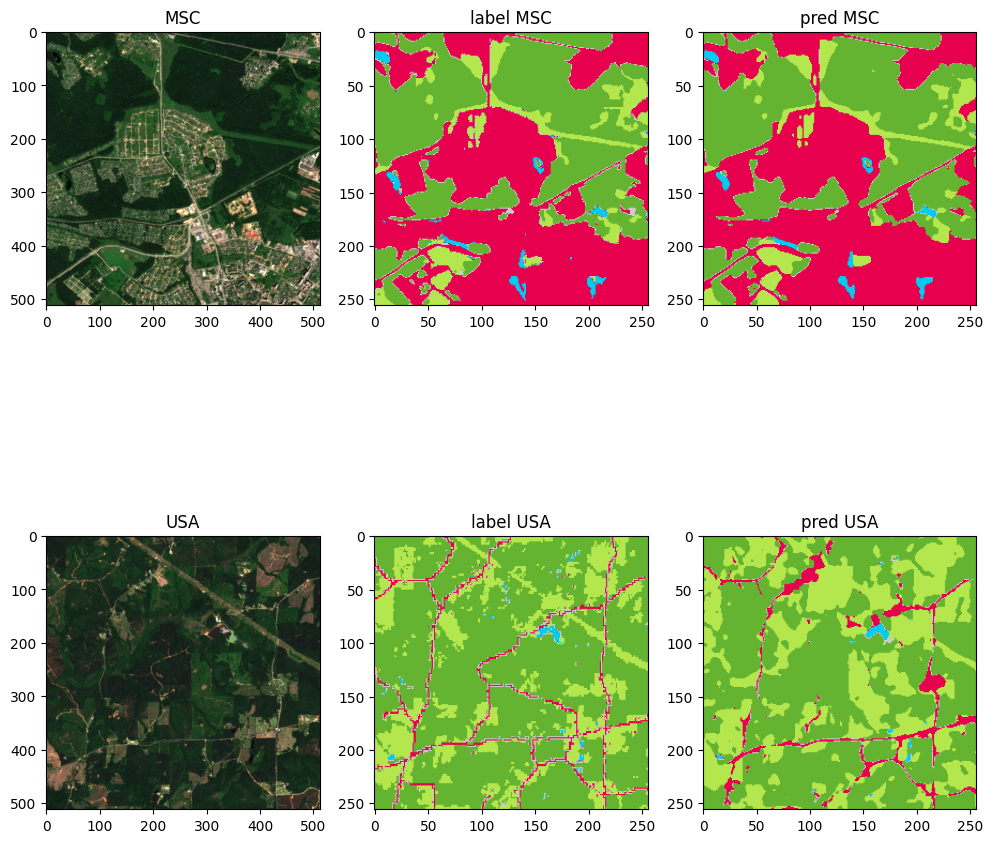

{'msc': {'IOS open water': 0.85225785,
  'IOS settlements': 0.8258599,
  'IOS bare soil': 0.23761864,
  'IOS forest': 0.9453565,
  'IOS grassland': 0.86498266,
  'accuracy': 0.9475742622658059,
  'mean IOS': 0.7452151},
 'USA': {'IOS open water': 0.61029565,
  'IOS settlements': 0.3460274,
  'IOS bare soil': 0.06530125,
  'IOS forest': 0.78321165,
  'IOS grassland': 0.4912956,
  'accuracy': 0.7709150314331055,
  'mean IOS': 0.4592263}}

In [410]:
train_procedures.sainty_check(model, test_dataloader_usa, test_dataloader_msc, device, idxs=(1, 2))

In [38]:
wandb.finish()

IOS bare soil msc,▂▁▁▁▁▄▁▃▄▆▂▄▅▆▅▆▅▇▆▆▆▇▇▆▆█▄█▇▇▇█▆▇▇████▇
IOS forest msc,▁███████████████████████████████████████
IOS grassland msc,▁▇▇▇▇▇▇▇▇█▇█▇██▇████████████████████████
IOS open water msc,▁▇▇▇▇██▇████████████████████████████████
IOS settlements msc,▁▆▇▇▇▇▇▇██▇█▇███████████▇████████▇██████
accuracy msc,▁███████████████████████████████████████
epoch loss msc,█▃▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
last lr,▁▃▄▆▇███████████████▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅
mean IOS msc,▁▇▇▇▇▇▇▇██▇█▇███████████████████████████
IOS bare soil msc,0.09547
IOS forest msc,0.92324


### Data Matching

In [2]:
dataloder_common_masked = datasets.get_common_masked_dataloader(batch_size=32)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
_, test_dataloader_msc = datasets.get_dataloaders_msc(32)
_, test_dataloader_usa = datasets.get_dataloaders_usa(32)

In [4]:
reload(datasets)
reload(train_procedures)
reload(losses)
reload(utils)
reload(models)

<module 'models' from '/trinity/home/team18/workspace/models.py'>

In [ ]:
config = configparser.ConfigParser()
config.read("config.ini")

opt_lr = json.loads(config.get("training", "opt_lr"))
name = config.get("meta", "name")
encoder_name = config.get("meta", "encoder_name")
description = config.get("meta", "description")
epoch_t = json.loads(config.get("training", "epoch_t"))
device = torch.device("cuda")

wandb.login()
run = wandb.init(
    # Set the project where this run will be logged
    project="SMILES2024",
    name = name,
    notes = description,
    # Track hyperparameters and run metadata
    config = {"opt_lr": opt_lr}
)

model = smp.Unet(
encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=5,                      # model output channels (number of classes in your dataset)
)

encoder = models.EncoderModel(model.encoder).to("cuda")

device = torch.device("cuda")
opt = torch.optim.Adam(model.parameters(), lr=opt_lr)    
scheduler = train_procedures.get_scheduler(opt, config)
distance = losses.DistanceSinkhorn()
loss = losses.SegMathcingLoss(lambdas=(0.0, 0.0, 0.0, 0.02, 0.05, 0.1), distance=distance).to(device)

model = train_procedures.train_main_model(model, loss, opt, scheduler, dataloder_common_masked, test_dataloader_msc,
                                          test_dataloader_usa, name, epoch_t=epoch_t, device=device,
                                          log_flag=True, train_area="msc", test_area_1="msc", test_area_2="usa")
wandb.finish()

wandb: Currently logged in as: a-samsonenko (itc_samsonenko). Use `wandb login --relogin` to force relogin


  2%|▎         | 10/400 [04:43<3:03:16, 28.20s/it]

In [166]:
wandb.finish()

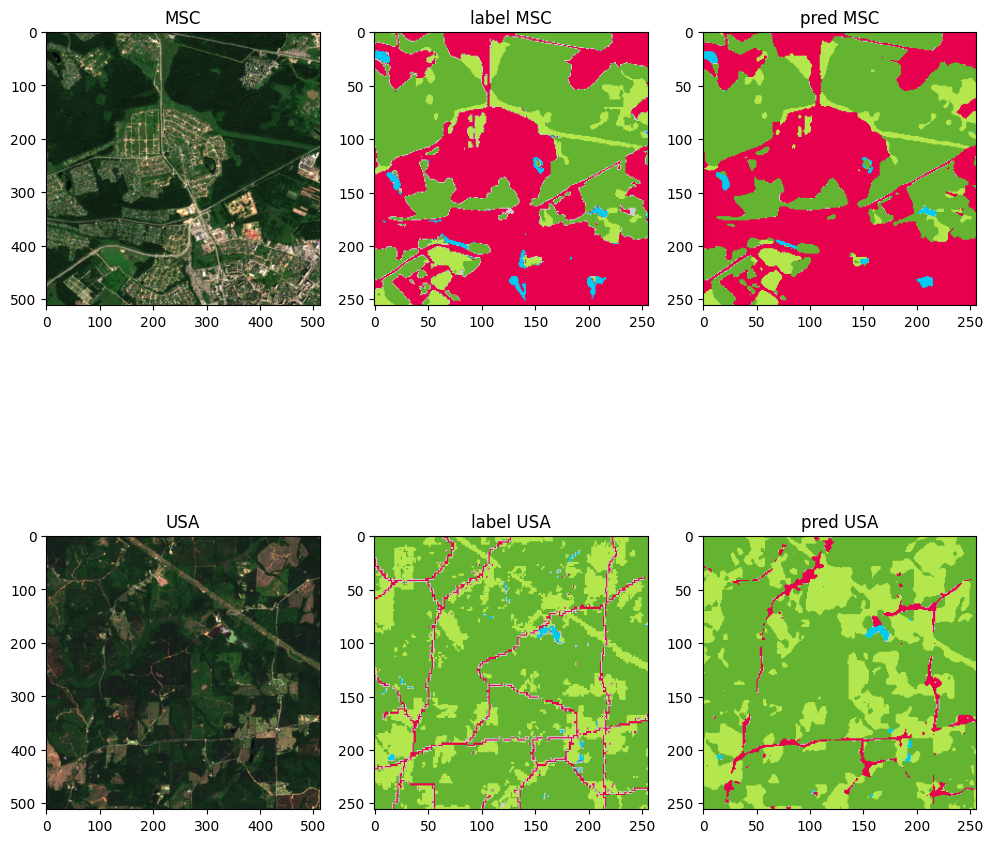

{'msc': {'IOS open water': 0.77682126,
  'IOS settlements': 0.75854725,
  'IOS bare soil': 0.11770616,
  'IOS forest': 0.920851,
  'IOS grassland': 0.79744136,
  'accuracy': 0.9254705641004775,
  'mean IOS': 0.6742734},
 'USA': {'IOS open water': 0.6080388,
  'IOS settlements': 0.35096237,
  'IOS bare soil': 0.040629063,
  'IOS forest': 0.7968435,
  'IOS grassland': 0.51321906,
  'accuracy': 0.7844086289405823,
  'mean IOS': 0.46193856}}

In [164]:
train_procedures.sainty_check(model, test_dataloader_usa, test_dataloader_msc, device, idxs=(1, 2))

### Data MINING

In [65]:
dataloder_common_bare = datasets.get_dataloaders_bare(batch_size=32)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
config = configparser.ConfigParser()
config.read("config.ini")

opt_lr = json.loads(config.get("training", "opt_lr"))
name = config.get("meta", "name")
encoder_name = config.get("meta", "encoder_name")
description = config.get("meta", "description")
epoch_t = json.loads(config.get("training", "epoch_t"))
device = torch.device("cuda")

wandb.login()
run = wandb.init(
    # Set the project where this run will be logged
    project="SMILES2024",
    name = name,
    notes = description,
    # Track hyperparameters and run metadata
    config = {"opt_lr": opt_lr}
)


model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

device = torch.device("cuda")
opt = torch.optim.Adam(model.parameters(), lr=opt_lr)    
scheduler = train_procedures.get_scheduler(opt, config)
distance = losses.DistanceSinkhorn()
loss = losses.SoftDiceCrossLoss(loss_weights=(0.5, 0.5)).to(device)

model = train_procedures.train_main_model(model, loss, opt, scheduler, dataloder_common_bare, test_dataloader_msc, name, epoch_t=epoch_t, device=device,
                                 log_flag=True, train_area="common", test_area="msc")
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


  0%|          | 1/200 [00:09<32:11,  9.70s/it]

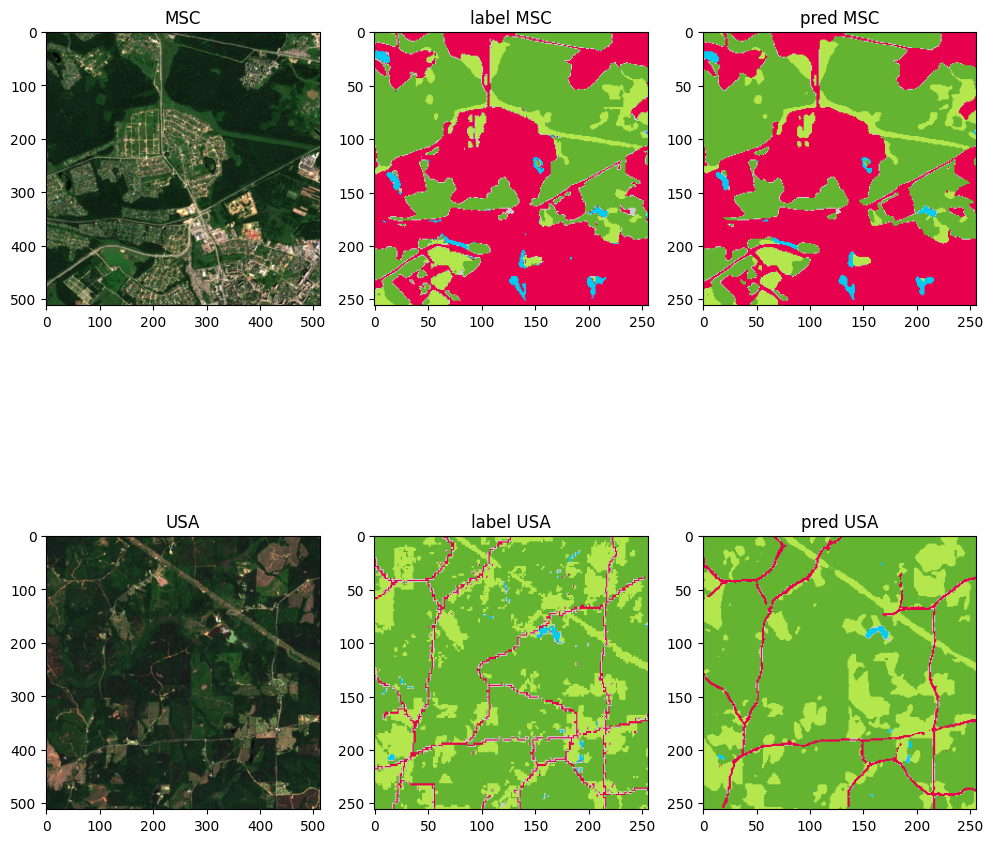

{'msc': {'IOS open water': 0.7835442,
  'IOS settlements': 0.7678952,
  'IOS bare soil': 0.19569908,
  'IOS forest': 0.92004085,
  'IOS grassland': 0.8005082,
  'accuracy': 0.9252755200421369,
  'mean IOS': 0.69353753},
 'USA': {'IOS open water': 0.62806803,
  'IOS settlements': 0.4416801,
  'IOS bare soil': 0.054848965,
  'IOS forest': 0.83551073,
  'IOS grassland': 0.61632395,
  'accuracy': 0.8334145545959473,
  'mean IOS': 0.5152863}}

In [69]:
train_procedures.sainty_check(model, test_dataloader_usa, test_dataloader_msc, device, idxs=(1, 2))

### PCA and T-sne

In [177]:
model = smp.Unet(
encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=5,                      # model output channels (number of classes in your dataset)
)
state_dict = torch.load("./saved_data/Matching_Sinkhorn_clean_v2/final")
model.load_state_dict(state_dict)

encoder = models.EncoderModel(model.encoder).to("cuda")

In [178]:
reload(datasets)
reload(train_procedures)
reload(losses)
reload(utils)
reload(models)

<module 'models' from '/trinity/home/team18/workspace/models.py'>

In [179]:
encoder = models.EncoderModel(model.encoder).to("cuda")

In [180]:
with torch.no_grad():
    embedings_usa = []
    for batch in test_dataloader_usa:
        embed = encoder(batch[0].cuda()).cpu().numpy()
        embedings_usa.append(embed)
    embedings_usa =  np.concatenate(embedings_usa)
    targets_usa = np.ones(len(embedings_usa))
    
    embedings_msc = []
    for batch in test_dataloader_msc:
        embed = encoder(batch[0].cuda()).cpu().numpy()
        embedings_msc.append(embed)
    embedings_msc =  np.concatenate(embedings_msc)
    targets_msc = np.zeros(len(embedings_msc))

embedings = np.concatenate((embedings_usa, embedings_msc))
targets = np.concatenate((targets_usa, targets_msc))

In [181]:
embedings_msc.shape

(1703, 2048)

In [182]:
from sklearn import datasets, decomposition
import matplotlib.pyplot as plt

pca = decomposition.PCA(n_components=3)
pca.fit(embedings)
embedings = pca.transform(embedings)
embedings[:, 0] = embedings[:, 0]

/trinity/home/team18/workspace/ipykernel_1122166/1893542681.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedings[targets==0, 0], embedings[targets==0, 1], cmap=plt.cm.nipy_spectral, s=1.5)
/trinity/home/team18/workspace/ipykernel_1122166/1893542681.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedings[targets==1, 0], embedings[targets==1, 1], cmap=plt.cm.nipy_spectral, s=1.5)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


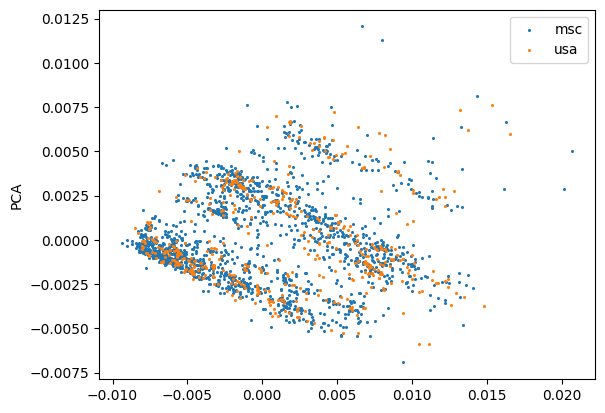

In [183]:
plt.scatter(embedings[targets==0, 0], embedings[targets==0, 1], cmap=plt.cm.nipy_spectral, s=1.5)
plt.scatter(embedings[targets==1, 0], embedings[targets==1, 1], cmap=plt.cm.nipy_spectral, s=1.5)
plt.legend(("msc", "usa"))
#plt.xlim(-2,5)
plt.ylabel('PCA')
plt.savefig('PCA_mosckow_layer_scaled.eps')